# Exploring Comcast Customer Interaction Data
Load sample data, flatten JSON structures, understand the meaning of various status and reason codes, construct time series, look for identifying patterns and construct candidate features.

## Preliminaries
Set up credentials and functions for file I/O, enable PixieDust for visualization.

In [1]:
# The code was removed by DSX for sharing.

In [2]:
# Allow display of multiple values without using print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pixiedust

Pixiedust database opened successfully


## Load the raw sample data
And take a look at what's in it.

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df_raw = (spark.read
               .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')
               .option('header', 'false')
               .option('sep', '|')
               .load(bmos.url('CableCompany', 'limitedJsonMachinelearning.csv')))

In [5]:
spark.version

'2.0.2'

In [ ]:
display(df_raw)

_c0,_c1
10050788972,"{""msg"":{""body"":{""Account"":{""AccountId"":10050788972,""ConnectDate"":""2012-11-09"",""Delinquency"":{""Status"":""C""},""DisconnectDate"":""2017-07-31""},""Order"":{""Status"":""C"",""ReasonCodeDescription"":""S-Verizon Fios (Fiber)"",""OrderId"":7625192014,""Class"":""S"",""ReasonCode"":""O2""}},""head"":{""TriggerDate"":""2017-07-31"",""TriggerTime"":""04:17:56"",""Origin"":""LAZIA:17-BEP ORDER DETAIL UPDATED""}}}"
10050788972,"{""msg"":{""body"":{""Account"":{""AccountId"":10050788972,""ConnectDate"":""2012-11-09"",""Delinquency"":{""Status"":""V""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""O"",""ReasonCodeDescription"":""S-Verizon Fios (Fiber)"",""OrderId"":7625192014,""Class"":""S"",""ReasonCode"":""O2""}},""head"":{""TriggerDate"":""2017-07-29"",""TriggerTime"":""03:01:59"",""Origin"":""LAZIA:17-BEP ORDER DETAIL UPDATED""}}}"
10021901902,"{""msg"":{""body"":{""Account"":{""AccountId"":10021901902,""ConnectDate"":""0001-01-01"",""Delinquency"":{""Status"":""""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""O"",""ReasonCodeDescription"":""Channel-Web Order"",""OrderId"":6100262011,""Class"":""S"",""ReasonCode"":""SJ""}},""head"":{""TriggerDate"":""2017-07-23"",""TriggerTime"":""15:01:20"",""Origin"":""LAZIA:18-BEP ORDER DETAIL UPDATED""}}}"
10021901902,"{""msg"":{""body"":{""Account"":{""AccountId"":10021901902,""ConnectDate"":""0001-01-01"",""Delinquency"":{""Status"":""""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""O"",""ReasonCodeDescription"":""Tech Assist"",""OrderId"":7630882013,""Class"":""M"",""ReasonCode"":18}},""head"":{""TriggerDate"":""2017-07-28"",""TriggerTime"":""13:12:41"",""Origin"":""LAZIH:18-BEP TRBL CALL SPEC REQ (PRD)""}}}"
10021901902,"{""msg"":{""body"":{""Account"":{""AccountId"":10021901902,""ConnectDate"":""2017-07-28"",""Delinquency"":{""Status"":""""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""C"",""ReasonCodeDescription"":""Channel-Web Order"",""OrderId"":6100262011,""Class"":""S"",""ReasonCode"":""SJ""}},""head"":{""TriggerDate"":""2017-07-28"",""TriggerTime"":""13:43:47"",""Origin"":""LAZIA:18-BEP ORDER DETAIL UPDATED""}}}"
10021901902,"{""msg"":{""body"":{""Account"":{""AccountId"":10021901902,""ConnectDate"":""0001-01-01"",""Delinquency"":{""Status"":""""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""O"",""ReasonCodeDescription"":""Channel-Web Order"",""OrderId"":6100262011,""Class"":""S"",""ReasonCode"":""SJ""}},""head"":{""TriggerDate"":""2017-07-23"",""TriggerTime"":""13:24:51"",""Origin"":""LAZIA:18-BEP ORDER DETAIL UPDATED""}}}"
10021901902,"{""msg"":{""body"":{""Account"":{""AccountId"":10021901902,""ConnectDate"":""0001-01-01"",""Delinquency"":{""Status"":""""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""O"",""ReasonCodeDescription"":""Channel-Web Order"",""OrderId"":6100262011,""Class"":""S"",""ReasonCode"":""SJ""}},""head"":{""TriggerDate"":""2017-07-27"",""TriggerTime"":""16:21:05"",""Origin"":""LAZII:18-BEP JOBS UPDT_RESCHD CALL AHD CHG (PRD)""}}}"
10021901902,"{""msg"":{""body"":{""Account"":{""AccountId"":10021901902,""ConnectDate"":""2017-07-28"",""Delinquency"":{""Status"":""""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""C"",""ReasonCodeDescription"":""Tech Assist"",""OrderId"":7630882013,""Class"":""M"",""ReasonCode"":18}},""head"":{""TriggerDate"":""2017-07-28"",""TriggerTime"":""13:51:36"",""Origin"":""LAZIH:18-BEP TRBL CALL SPEC REQ (PRD)""}}}"
10021821894,"{""msg"":{""body"":{""Account"":{""AccountId"":10021821894,""ConnectDate"":""2016-08-24"",""Delinquency"":{""Status"":""V""},""DisconnectDate"":""0001-01-01""},""Order"":{""Status"":""O"",""ReasonCodeDescription"":""P-Transfers Of Service"",""OrderId"":7624552010,""Class"":""S"",""ReasonCode"":""OT""}},""head"":{""TriggerDate"":""2017-07-28"",""TriggerTime"":""12:50:10"",""Origin"":""LAZIA:03-BEP ORDER DETAIL UPDATED""}}}"
10021821894,"{""msg"":{""body"":{""Account"":{""AccountId"":10021

### There's several observations per account id
They make up the time sequence for a given account

In [7]:
df_raw.groupBy('_c0').count().show(5)

+-----------+-----+
|        _c0|count|
+-----------+-----+
|01310054795|    6|
|14020037713|    5|
|10260163980|    8|
|00410047615|    3|
|03760179416|    4|
+-----------+-----+
only showing top 5 rows



## Work out the dataframe schema from the JSON records
### Get the JSON structure by looking at one record
This assumes that all entries have the same structure.

At this point, we can ignore the first column, which is a repeat of the "AccountId" element in the JSON record. In real work, it may be useful to take advantage of such redundancy for one more consistency check, but in this case we may just be seeing an artifact of the way the sample dataset was prepared.

In [8]:
# The json module can pretty-print a JSON structure.
# Read the string into a JSON object, then dump it out again
# into a string, with indent.
import json
one_json = df_raw.first()._c1
print(one_json)
print(json.dumps(json.loads(one_json), sort_keys=True, indent=4))

{"msg":{"body":{"Account":{"AccountId":10050788972,"ConnectDate":"2012-11-09","Delinquency":{"Status":"C"},"DisconnectDate":"2017-07-31"},"Order":{"Status":"C","ReasonCodeDescription":"S-Verizon Fios (Fiber)","OrderId":7625192014,"Class":"S","ReasonCode":"O2"}},"head":{"TriggerDate":"2017-07-31","TriggerTime":"04:17:56","Origin":"LAZIA:17-BEP ORDER DETAIL UPDATED"}}}
{
    "msg": {
        "body": {
            "Account": {
                "AccountId": 10050788972,
                "ConnectDate": "2012-11-09",
                "Delinquency": {
                    "Status": "C"
                },
                "DisconnectDate": "2017-07-31"
            },
            "Order": {
                "Class": "S",
                "OrderId": 7625192014,
                "ReasonCode": "O2",
                "ReasonCodeDescription": "S-Verizon Fios (Fiber)",
                "Status": "C"
            }
        },
        "head": {
            "Origin": "LAZIA:17-BEP ORDER DETAIL UPDATED",
          

### Fix one problem: ID strings
Account and Order IDs look like numbers but leading zeros are significant and the number of digits should always be the same. So they must be quoted to avoid misinterpretation by json reader and schema inference.

Note that the pyspark json reader has options `allowNumericLeadingZero` and `PrimitivesAsString`, which look like they shouid help, but in testing they did not correctly interpret records containing IDs with leading zeros if they were left unquoted.

In [9]:
# Quote all values that are unquoted numeric strings.
from pyspark.sql.functions import regexp_replace
df_fixed = df_raw.withColumn('fixed', regexp_replace('_c1', ':(\d+),', ':"$1",'))
df_fixed.first().fixed   # Just verify that "AccountId" and "OrderId" values are double-quoted.

'{"msg":{"body":{"Account":{"AccountId":"10050788972","ConnectDate":"2012-11-09","Delinquency":{"Status":"C"},"DisconnectDate":"2017-07-31"},"Order":{"Status":"C","ReasonCodeDescription":"S-Verizon Fios (Fiber)","OrderId":"7625192014","Class":"S","ReasonCode":"O2"}},"head":{"TriggerDate":"2017-07-31","TriggerTime":"04:17:56","Origin":"LAZIA:17-BEP ORDER DETAIL UPDATED"}}}'

### Flatten the JSON records
In two steps:
1. Convert JSON strings to Python `struct`s
1. Flatten the `struct`s into multiple columns

In [10]:
# Transform the column with JSON strings into one with corresponding python structs.
# Do this by using the JSON dataframe reader against an RDD with just those strings.
# Since we want all elements to be strings and there are no other mysteries, it's OK
# to let the reader infer the schema.

# Note, however, in the structs in the msg column as well as in the schema, this sequence:
#                 ..., S'=['tatus=None, Status=...
# This must be an artifact (bug?) of the json reader. The entire part
#                 , S'=['tatus=None
# should not be there.

df_struct = spark.read.json(df_fixed
                            .select('fixed')        # Just the column with the quoted numerics
                            .rdd                    # Convert to RDD (of Rows with a single column)
                            .map(lambda x: x.fixed) # Extract just the string (not wrapped in a Row)
                           )
df_struct.printSchema()

root
 |-- msg: struct (nullable = true)
 |    |-- body: struct (nullable = true)
 |    |    |-- Account: struct (nullable = true)
 |    |    |    |-- AccountId: string (nullable = true)
 |    |    |    |-- ConnectDate: string (nullable = true)
 |    |    |    |-- Delinquency: struct (nullable = true)
 |    |    |    |    |-- Status: string (nullable = true)
 |    |    |    |-- DisconnectDate: string (nullable = true)
 |    |    |-- Order: struct (nullable = true)
 |    |    |    |-- Class: string (nullable = true)
 |    |    |    |-- OrderId: string (nullable = true)
 |    |    |    |-- ReasonCode: string (nullable = true)
 |    |    |    |-- ReasonCodeDescription: string (nullable = true)
 |    |    |    |-- S'=['tatus: string (nullable = true)
 |    |    |    |-- Status: string (nullable = true)
 |    |-- head: struct (nullable = true)
 |    |    |-- Origin: string (nullable = true)
 |    |    |-- TriggerDate: string (nullable = true)
 |    |    |-- TriggerTime: string (nullable = tr

In [11]:
df_struct.first().msg

Row(body=Row(Account=Row(AccountId='10050788972', ConnectDate='2012-11-09', Delinquency=Row(Status='C'), DisconnectDate='2017-07-31'), Order=Row(Class='S', OrderId='7625192014', ReasonCode='O2', ReasonCodeDescription='S-Verizon Fios (Fiber)', S'=['tatus=None, Status='C')), head=Row(Origin='LAZIA:17-BEP ORDER DETAIL UPDATED', TriggerDate='2017-07-31', TriggerTime='04:17:56'))

In [14]:
# Now flatten the structs. Drop and rename columns for consistency.
# Structs can be expanded with simple suffix notation. '.*' gets all child elements; repeat this
# for all levels.
# This is not generalized for any structure; instead, it requires manual inspection of
# the current schema and knowledge of the desired output.

from pyspark.sql.functions import col

df1 = (df_struct
         .select('msg.*')
         .select('body.*', 'head.*')
         .select('Account.*', 'Order.*', 'Origin', 'TriggerDate', 'TriggerTime')
         .withColumn('AccountDelinquencyStatus',col('Delinquency.Status'))
         .drop('Delinquency')
         .drop("S'=['tatus")                          # No idea why this ends up in the structs produced by the json reader
         .withColumnRenamed('Status', 'OrderStatus')
         .withColumnRenamed('Class', 'OrderClass')
         .withColumnRenamed('ReasonCode', 'OrderReasonCode')
         .withColumnRenamed('ReasonCodedescription', 'OrderReasonCodeDescription')
      )
df1.printSchema()

root
 |-- AccountId: string (nullable = true)
 |-- ConnectDate: string (nullable = true)
 |-- DisconnectDate: string (nullable = true)
 |-- OrderClass: string (nullable = true)
 |-- OrderId: string (nullable = true)
 |-- OrderReasonCode: string (nullable = true)
 |-- OrderReasonCodeDescription: string (nullable = true)
 |-- OrderStatus: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- TriggerDate: string (nullable = true)
 |-- TriggerTime: string (nullable = true)
 |-- AccountDelinquencyStatus: string (nullable = true)



## Explore Data after json flattening

In [15]:
print('Shape: {} × {}'.format(df1.count(), len(df1.columns)))

Shape: 3308 × 12


### Lookup dictionaries for status and class codes
These come in handy when interpreting one-letter codes

In [16]:
status_codes = {
    '':'Normal',
    'A':'Open non-pay disconnect and equipment is active',
    'C':'Voluntary disconnect',
    'E':'Non-pay disconnect',
    'F':'Open non-pay disconnect and equipment is force tuned',
    'P':'Pending non-pay disconnect and services are restored; CSG assigns this status in real time',
    'S':'Pending change of service job (applies to subscription billing)',
    'T':'PPV ordering restricted',
    'V':'Open voluntary disconnect job',
    'W':'Open non-pay disconnect and equipment is disabled',
    'Z':'Charged off'
}

class_codes = {
    'M':'Special request',
    'S':'Service order',
    'T':'Trouble call'
}

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

get_status = udf(lambda x: status_codes.get(x), StringType())
(df1
 .select(get_status('AccountDelinquencyStatus')
         .alias('DelinquencyStatus')
        )
 .groupby('DelinquencyStatus')
 .count()
 .orderBy('count', ascending=False)
 .show()
)

+--------------------+-----+
|   DelinquencyStatus|count|
+--------------------+-----+
|              Normal| 2581|
|Open non-pay disc...|  192|
|Open non-pay disc...|  137|
|Open voluntary di...|  133|
|Voluntary disconnect|  118|
|Pending non-pay d...|   98|
|PPV ordering rest...|   31|
|  Non-pay disconnect|   14|
|         Charged off|    4|
+--------------------+-----+



In [21]:
(df1
 .select(udf(lambda x: class_codes.get(x), StringType())('OrderClass')
         .alias('OrderClass')
        )
 .groupby('OrderClass')
 .count()
 .orderBy('count', ascending=False)
 .show()
)

+---------------+-----+
|     OrderClass|count|
+---------------+-----+
|  Service order| 2623|
|   Trouble call|  437|
|Special request|  248|
+---------------+-----+




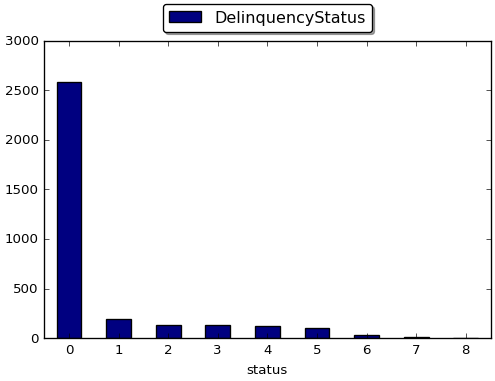

In [35]:
# This is an example of using PixieDust to create a visual representation
# Use both table and bar chart views
from pyspark.sql.functions import monotonically_increasing_id

df_status = (df1
             .groupby('AccountDelinquencyStatus')
             .count()
             .orderBy('count', ascending=False)
             .withColumnRenamed('count','DelinquencyStatus')
             .replace('', 'N')
             .repartition(1)      # Otherwise the row IDs will not be contiguous
             .withColumn('status', monotonically_increasing_id())
            )
display(df_status)

In [38]:
(df1
 .select('OrderReasonCode', 'OrderReasonCodeDescription')
 .distinct()
 .show(20)
)

+---------------+--------------------------+
|OrderReasonCode|OrderReasonCodeDescription|
+---------------+--------------------------+
|             OV|             P-Competition|
|             C4|                 TV Tiling|
|             C6|            TV Remote Prob|
|             OY|      P-Dissatisfied Cu...|
|             SC|                 Cssr Sale|
|             H5|            Int Speed Prob|
|             11|               Verify Svcs|
|             01|                TV All Out|
|             ZA|              Equip Pickup|
|             NP|                 P-Non Pay|
|             SH|               Channel-Dsr|
|             C3|             TV Audio Prob|
|             XY|           X Data Integrty|
|             SP|      Channel-Front Cou...|
|             BA|        Bc-Tech Assist 2Hr|
|             X3|            Xh Tch Scn Prb|
|             CF|              TV Hddta/Dta|
|             01|                  No Cable|
|             CD|       Cdo Proactive Visit|
|         

## Construct per-account time series
The original data has one record per customer interaction (Order ID), with multiple records
per customer (Account ID). Since each customer's history is independent of all the others, it
makes sense to aggregate each history into a single row, one for each Account ID. The codes
for each interaction can be concatenated, in time order, to form a time series of codes. These
will form the basis of features and labels we can use to build models.

#### Create the concatenated time series
Turn each sequence of single-character codes into a single string. For the two-charcter
reason codes, separate them by an inobtrusive character, like a period. (Better not use comma,
as that would cause issues when writing a CSV file.)

In [ ]:
from pyspark.sql.functions import collect_list, concat, concat_ws

concat = udf(lambda x:''.join(x))
concat_dot = udf(lambda x: '.'.join(x))

df2 = (df1.replace('','N')
          .orderBy(['TriggerDate', 'TriggerTime'])
          .groupby('AccountId')
          .agg(
                collect_list('OrderClass').alias('OrderClass'),
                collect_list('AccountDelinquencyStatus').alias('AccountDelinquencyStatus'),
                collect_list('OrderReasonCode').alias('OrderReasonCode'),
                collect_list('OrderStatus').alias('OrderStatus')
          )
          .withColumn('OrderClass', concat('OrderClass'))
          .withColumn('AccountDelinquencyStatus', concat('AccountDelinquencyStatus'))
          .withColumn('OrderReasonCode', concat_dot('OrderReasonCode'))
          .withColumn('OrderStatus', concat('OrderStatus'))
)

In [50]:
df2.show()

+-----------+------------+------------------------+--------------------+------------+
|  AccountId|  OrderClass|AccountDelinquencyStatus|     OrderReasonCode| OrderStatus|
+-----------+------------+------------------------+--------------------+------------+
|00410047615|         SSS|                     NNN|            NT.DF.DF|         CCC|
|01310054795|      STMMMT|                  NNNNNN|   NT.F0.28.28.28.F0|      COCOOX|
|10260163980|    SSSSSSSS|                NNNNNNNN|00.00.00.00.XX.XX...|    OOOCCCOO|
|14020037713|       SSSSS|                   NNNNN|      NT.NT.NT.NT.NT|       CCCCC|
|00091876502|         SSS|                     VVC|            OT.OT.OT|         OOC|
|03321183668|     SSSSSSS|                 NNNNNNN|OT.OT.OT.OT.OT.OT.OT|     OOOCOOO|
|03760179416|        SSSS|                    NNNN|         DF.DF.DF.DF|        OCOC|
|10080033067|      STTTST|                  NNNNNN|   DF.H4.H4.H4.NT.H4|      COOCCO|
|10260496158|         SSS|                     VVN|   

## Write the per-account time series to a file
To make the data accessible to other notebooks in the project.

NOTE: Do this only once.

## Minor problem diagnosis
### One account ID from the original data is missing from the current dataframe
Find out why.

#### The current dataframe has 573 rows, but the original data has 574 unique account IDs

In [52]:
df2.count()

573

In [59]:
df_raw.select('_c0').distinct().count()

574

#### The difference is one corrupted version of an existing account ID
See the table two cells down.

As part of data cleansing, we may want to look for things like this and fix them. For now, assume that this may be an artifact of preparing the sample data set and in any case is insignificant. It's OK to ignore that record.

In [65]:
(set(df_raw
     .select('_c0')
     .rdd
     .map(lambda r: r._c0)
     .collect()
    )
 .difference(set(df2
                 .select('AccountId')
                 .rdd
                 .map(lambda r: r.AccountId)
                 .collect()
                )
            )
)

{'][][00762520805'}

In [68]:
df_raw.createOrReplaceTempView('raw')
spark.sql('SELECT * FROM raw WHERE _c0 LIKE "][][%" OR _c0 LIKE "007%"').show()

+---------------+--------------------+
|            _c0|                 _c1|
+---------------+--------------------+
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00731096810|{"msg":{"body":{"...|
|    00710503739|{"msg":{"body":{"...|
|    00710503739|{"msg":{"body":{"...|
|    00710503739|{"msg":{"body":{"...|
|    00710503739|{"msg":{"body":{"...|
|    00710503739|{"msg":{"body":{"...|
|][][00762520805|{"msg":{"body":{"...|
|    00762520805|{"msg":{"body":{"...|
|    00762520805|{"msg":{"body":{"...|
|    00710757699|{"msg":{"body":{"...|
|    00710757699|{"msg":{"body":{"...|
+---------------+--------------------+
only showing top 20 rows

